# Chapter 4: Exercise 13

- Weekly percentage returns for the S&P 500 stock index between 1990 and 2010.
- Year: The year that the observation was recorded
- Lag1: Percentage return for previous week
- Lag2: Percentage return for 2 weeks previous
- Lag3: Percentage return for 3 weeks previous
- Lag4: Percentage return for 4 weeks previous
- Lag5: Percentage return for 5 weeks previous
- Volume: Volume of shares traded (average number of daily shares traded in billions)
- Today: Percentage return for this week
- Direction: A factor with levels ‘Down’ and ‘Up’ indicating whether the market had a positive or negative return on a given week.

**Import packages**

In [1]:
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from sklearn.discriminant_analysis import \
    (LinearDiscriminantAnalysis as LDA,
     QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

### (a) Numerical and graphical summary of stock market data set

In [2]:
Weekly = load_data('Weekly')

In [3]:
Weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [4]:
Weekly.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


There does not appear to be any strong correlations between any of the variables other than year and volume as depicted in the graph below.

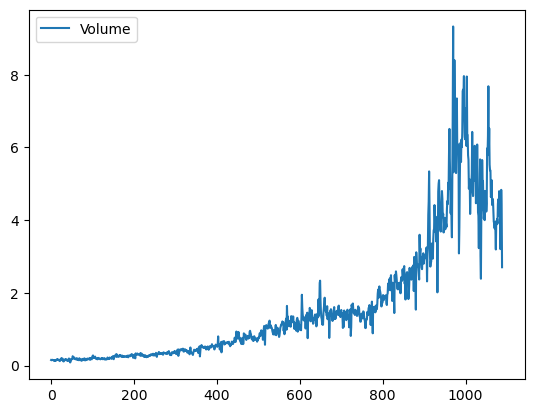

In [5]:
Weekly.plot(y='Volume');

### (b) Logistic regression with Direction as response, using Lag and Volume

In [6]:
allvars = Weekly.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Weekly)
y = Weekly.Direction == 'Up'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


The predictor **Lag2** appears to be statistically significant.

### (c) Confusion Matrix and overall fraction of correct predictions

In [7]:
probs = results.predict()

In [8]:
labels = np.array(['Down']*1089)
labels[probs > 0.5] = 'Up'

In [9]:
confusion_table(labels, Weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [10]:
(54+557)/1089, np.mean(labels == Weekly.Direction)

(0.5610651974288338, 0.5610651974288338)

We've correctly classified approximately 56% of the training observations.

False negative rate of 48/(48+54) = 47%

False positive rate of 430/(430+557) = 44%

False positive is bad since we predict the market is up when in fact it is down. This could be a lot of money lost on bad bets.

In [11]:
48/(48+54)

0.47058823529411764

In [12]:
430/(430+557)

0.43566362715298884

### (d) Logistic Regression using training period 1990 to 2008 with only Lag2 as predictor. Compute Confusion Matrix and overall fraction of correct predictions for test data 2009, 2010.

In [13]:
train = (Weekly.Year < 2009)

In [14]:
D = Weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [15]:
model = MS(['Lag2']).fit(Weekly)

In [16]:
X = model.transform(Weekly)
y = Weekly.Direction == 'Up'

In [17]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [18]:
(9+56)/104, np.mean(labels == L_test)

(0.625, 0.625)

Overall fraction of correct predictions is (9+56)/104 = 62.5%

### (e) Repeat (d) using LDA

In [19]:
lda = LDA(store_covariance=True)

In [20]:
X_train, X_test = [M.drop(columns=['intercept']) for M in [X_train, X_test]]

In [21]:
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [22]:
lda_pred = lda.predict(X_test)

In [23]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [24]:
(9+56)/104, np.mean(lda_pred == L_test)

(0.625, 0.625)

Overall fraction of correct predictions is (9+56)/104 = 62.5%

### (f) Repeat (d) using QDA

In [25]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [26]:
qda_pred = qda.predict(X_test)

In [27]:
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [28]:
np.mean(qda_pred == L_test)

0.5865384615384616

Overall fraction of correct predictions is 58.65%.

### (g) Repeat (d) using KNN with K = 1

In [29]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,22,31
Up,21,30


In [30]:
np.mean(knn1_pred == L_test)

0.5

Overall fraction of correct predictions is 50%.

### (h) Repeat (d) using naive Bayes

In [31]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

In [32]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [33]:
np.mean(nb_labels == L_test)

0.5865384615384616

Overall fraction of correct predictions is 58.65%.

### (i) Method providing the best results

Logistic Regression and LDA both accurately predict 62.5% of the test observations.

QDA and naive Bayes accurately predict 58.65% of the test observations by simply assigning all 'Up'.

KNN K = 1 accurately predicts 50%.



### (j) Experiment with different combinations of predictors, transformations of predictors, interactions of predictors, for each method including different values of K in KNN.

**Defining functions for pipeline**

In [34]:
# Logistic Regression
def logisticRegression(X_train, y_train, X_test, L_test):
    glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
    results = glm_train.fit()
    probs = results.predict(exog=X_test)
    labels = np.array(['Down']*104)
    labels[probs>0.5] = 'Up'
    return confusion_table(labels, L_test), np.mean(labels == L_test)

# lDA
def lda(X_train, L_train, X_test, L_test):
    lda = LDA(store_covariance=True)
    lda.fit(X_train, L_train)
    lda_pred = lda.predict(X_test)
    return confusion_table(lda_pred, L_test), np.mean(lda_pred == L_test)

# QDA
def qda(X_train, L_train, X_test, L_test):
    qda = QDA(store_covariance=True)
    qda.fit(X_train, L_train)
    qda_pred = qda.predict(X_test)
    return confusion_table(qda_pred, L_test), np.mean(qda_pred == L_test)

# Naive Bayes
def nb(X_train, L_train, X_test, L_test):
    NB = GaussianNB()
    NB.fit(X_train, L_train)
    nb_labels = NB.predict(X_test)
    return confusion_table(nb_labels, L_test), np.mean(nb_labels == L_test)

# KNN 
def knn(X_train, L_train, X_test, L_test, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, L_train)
    knn_pred = knn.predict(X_test)
    return confusion_table(knn_pred, L_test), np.mean(knn_pred == L_test)

In [35]:
D = Weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]

#### Compare Models Function

In [128]:
def compareModels(X, Weekly, train):    
    # Model Choice
    # model = MS(predictors).fit(Weekly)

    # X = model.transform(Weekly)
    y = Weekly.Direction == 'Up'
    X_train, X_test = X.loc[train], X.loc[~train]
    X_trainn, X_testt = [M.drop(columns=['intercept']) for M in [X_train, X_test]]
    y_train, y_test = y.loc[train], y.loc[~train]

    data = {}

    # Logistic Regression
    logConfusionTable, accuracy = logisticRegression(X_train, y_train, X_test, L_test)
    data['Logistic Regression']= accuracy

    # LDA
    confusionTable, accuracy = lda(X_trainn, L_train, X_testt, L_test)
    data['LDA']= accuracy

    # QDA
    confusionTable, accuracy = qda(X_trainn, L_train, X_testt, L_test)
    data['QDA']= accuracy

    # Naive Bayes
    confusionTable, accuracy = nb(X_trainn, L_train, X_testt, L_test)
    data['Naive Bayes']= accuracy

    # KNN
    confusionTable, accuracy = knn(X_trainn, L_train, X_testt, L_test, 1)
    data['KNN K=1']= accuracy

    confusionTable, accuracy = knn(X_trainn, L_train, X_testt, L_test, 2)
    data['KNN K=2']= accuracy

    confusionTable, accuracy = knn(X_trainn, L_train, X_testt, L_test, 5)
    data['KNN K=5']= accuracy

    confusionTable, accuracy = knn(X_trainn, L_train, X_testt, L_test, 10)
    data['KNN K=10']= accuracy

    confusionTable, accuracy = knn(X_trainn, L_train, X_testt, L_test, 15)
    data['KNN K=15']= accuracy

    confusionTable, accuracy = knn(X_trainn, L_train, X_testt, L_test, 20)
    data['KNN K=20']= accuracy

    confusionTable, accuracy = knn(X_trainn, L_train, X_testt, L_test, 25)
    data['KNN K=25']= accuracy

    # Creating bar graph
    acc = list(data.keys())
    model = list(data.values())
  
    fig = plt.figure(figsize = (15, 6))
    plt.bar(acc, model, width = 0.4)
 
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.title("Overall Fraction of Correct Predictions")
    plt.show()

    print(data)

    print('\n Max:',max(zip(data.values(), data.keys())), '\n\n', logConfusionTable)

#### Comparing Different Models

**Different Combinations of Predictors**

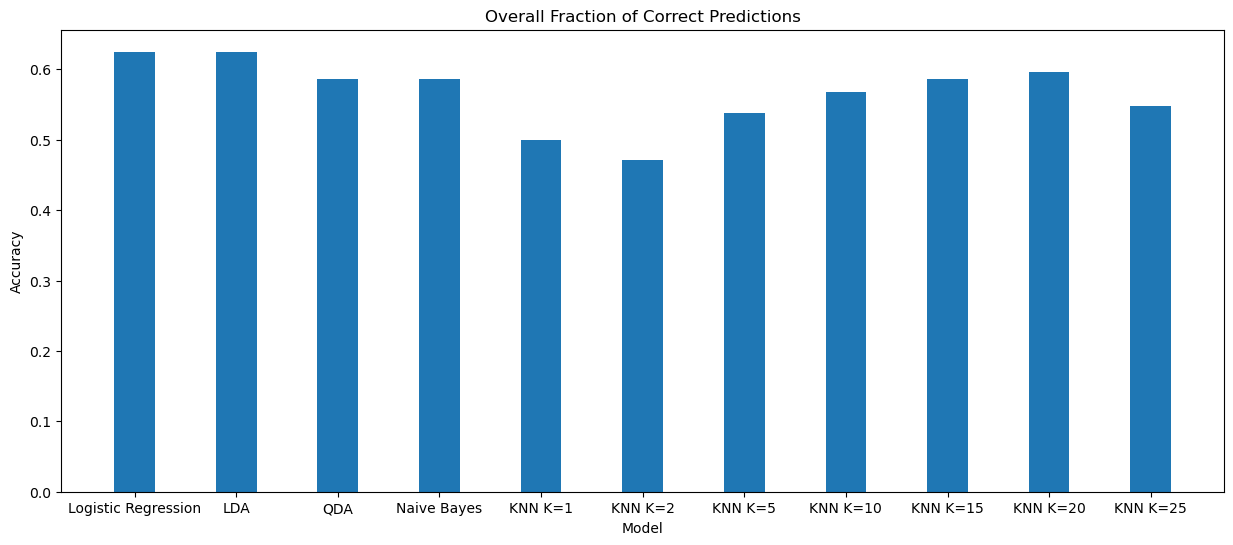

{'Logistic Regression': 0.625, 'LDA': 0.625, 'QDA': 0.5865384615384616, 'Naive Bayes': 0.5865384615384616, 'KNN K=1': 0.5, 'KNN K=2': 0.47115384615384615, 'KNN K=5': 0.5384615384615384, 'KNN K=10': 0.5673076923076923, 'KNN K=15': 0.5865384615384616, 'KNN K=20': 0.5961538461538461, 'KNN K=25': 0.5480769230769231}

 Max: (0.625, 'Logistic Regression')


In [90]:
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
compareModels(X, Weekly, train)

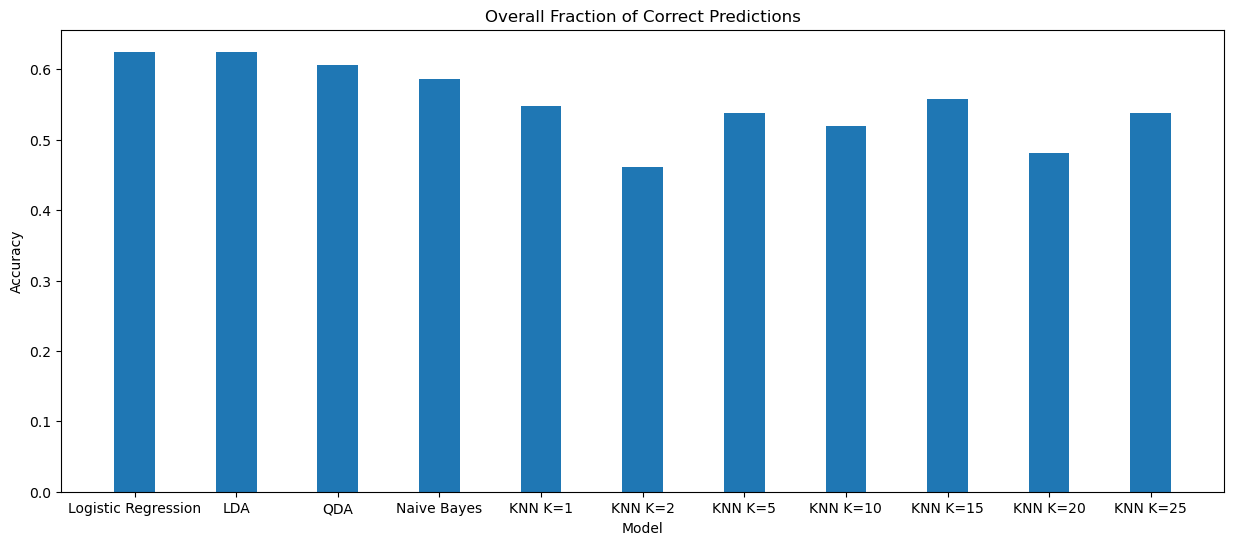

{'Logistic Regression': 0.625, 'LDA': 0.625, 'QDA': 0.6057692307692307, 'Naive Bayes': 0.5865384615384616, 'KNN K=1': 0.5480769230769231, 'KNN K=2': 0.46153846153846156, 'KNN K=5': 0.5384615384615384, 'KNN K=10': 0.5192307692307693, 'KNN K=15': 0.5576923076923077, 'KNN K=20': 0.4807692307692308, 'KNN K=25': 0.5384615384615384}

 Max: (0.625, 'Logistic Regression')


In [93]:
model = MS(['Lag2', 'Lag3']).fit(Weekly)
X = model.transform(Weekly)
compareModels(X, Weekly, train)

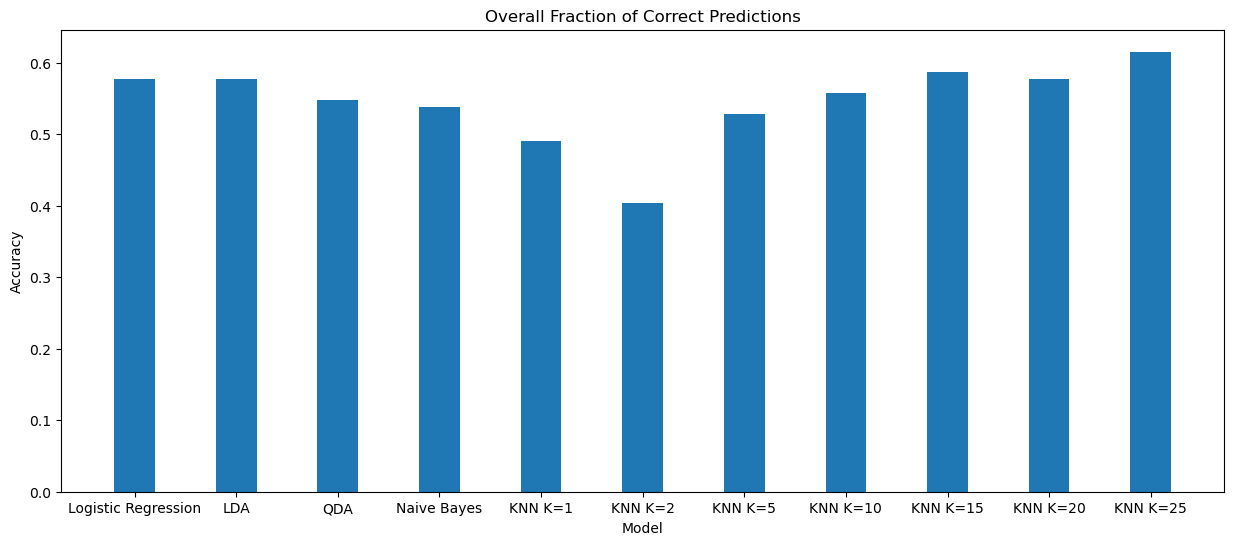

{'Logistic Regression': 0.5769230769230769, 'LDA': 0.5769230769230769, 'QDA': 0.5480769230769231, 'Naive Bayes': 0.5384615384615384, 'KNN K=1': 0.49038461538461536, 'KNN K=2': 0.40384615384615385, 'KNN K=5': 0.5288461538461539, 'KNN K=10': 0.5576923076923077, 'KNN K=15': 0.5865384615384616, 'KNN K=20': 0.5769230769230769, 'KNN K=25': 0.6153846153846154}

 Max: (0.6153846153846154, 'KNN K=25')


In [94]:
model = MS(['Lag1', 'Lag2', 'Lag3']).fit(Weekly)
X = model.transform(Weekly)
compareModels(X, Weekly, train)

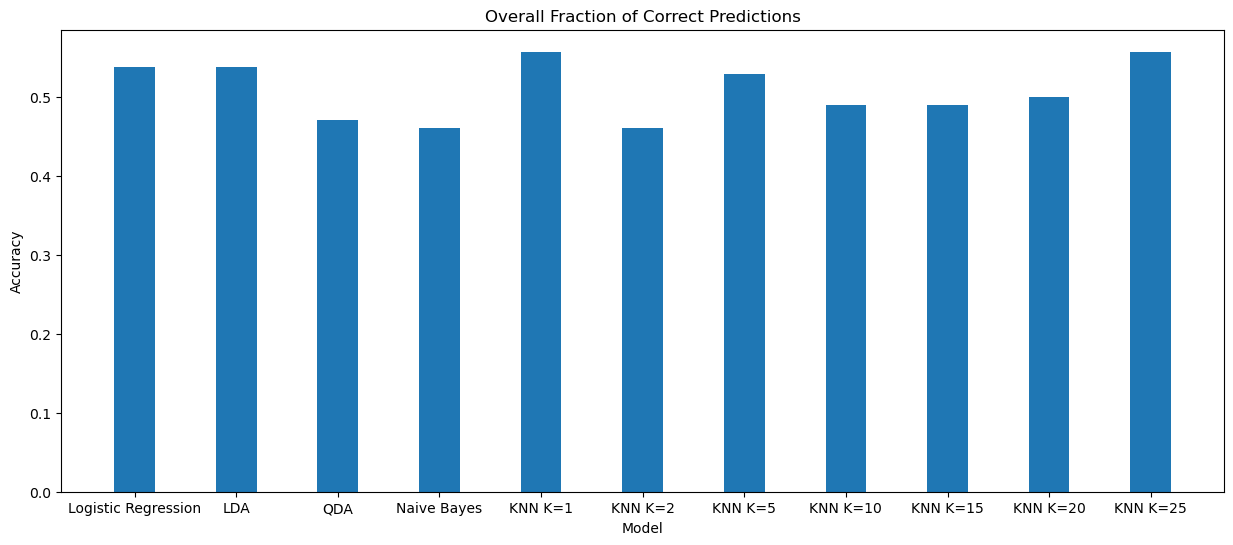

{'Logistic Regression': 0.5384615384615384, 'LDA': 0.5384615384615384, 'QDA': 0.47115384615384615, 'Naive Bayes': 0.46153846153846156, 'KNN K=1': 0.5576923076923077, 'KNN K=2': 0.46153846153846156, 'KNN K=5': 0.5288461538461539, 'KNN K=10': 0.49038461538461536, 'KNN K=15': 0.49038461538461536, 'KNN K=20': 0.5, 'KNN K=25': 0.5576923076923077}

 Max: (0.5576923076923077, 'KNN K=25')


In [95]:
model = MS(['Lag2', 'Volume']).fit(Weekly)
X = model.transform(Weekly)
compareModels(X, Weekly, train)

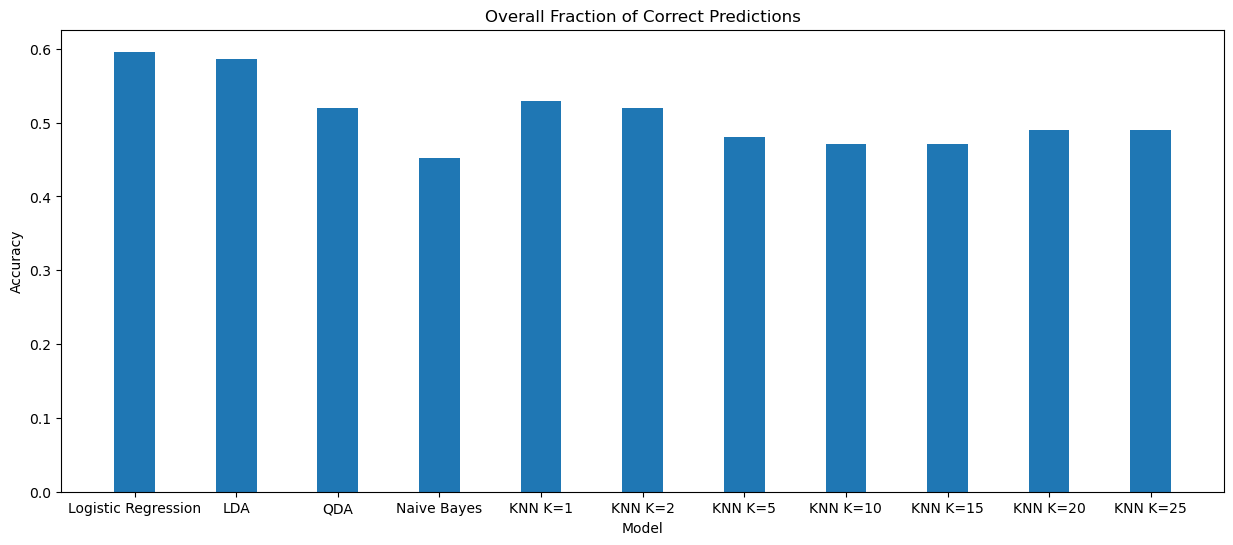

{'Logistic Regression': 0.5961538461538461, 'LDA': 0.5865384615384616, 'QDA': 0.5192307692307693, 'Naive Bayes': 0.4519230769230769, 'KNN K=1': 0.5288461538461539, 'KNN K=2': 0.5192307692307693, 'KNN K=5': 0.4807692307692308, 'KNN K=10': 0.47115384615384615, 'KNN K=15': 0.47115384615384615, 'KNN K=20': 0.49038461538461536, 'KNN K=25': 0.49038461538461536}

 Max: (0.5961538461538461, 'Logistic Regression')


In [96]:
model = MS(['Lag2', 'Year']).fit(Weekly)
X = model.transform(Weekly)
compareModels(X, Weekly, train)

**Different Interactions of Predictors**

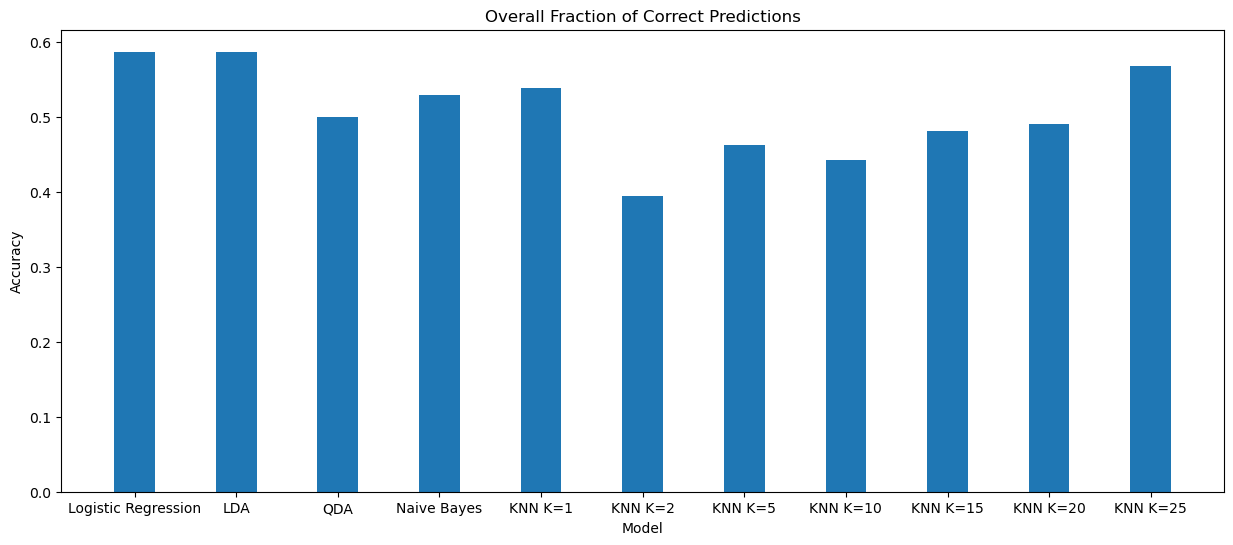

{'Logistic Regression': 0.5865384615384616, 'LDA': 0.5865384615384616, 'QDA': 0.5, 'Naive Bayes': 0.5288461538461539, 'KNN K=1': 0.5384615384615384, 'KNN K=2': 0.3942307692307692, 'KNN K=5': 0.46153846153846156, 'KNN K=10': 0.4423076923076923, 'KNN K=15': 0.4807692307692308, 'KNN K=20': 0.49038461538461536, 'KNN K=25': 0.5673076923076923}

 Max: (0.5865384615384616, 'Logistic Regression')


In [97]:
model = MS(['Lag2', ('Lag1','Lag3')]).fit(Weekly)
X = model.transform(Weekly)
compareModels(X, Weekly, train)

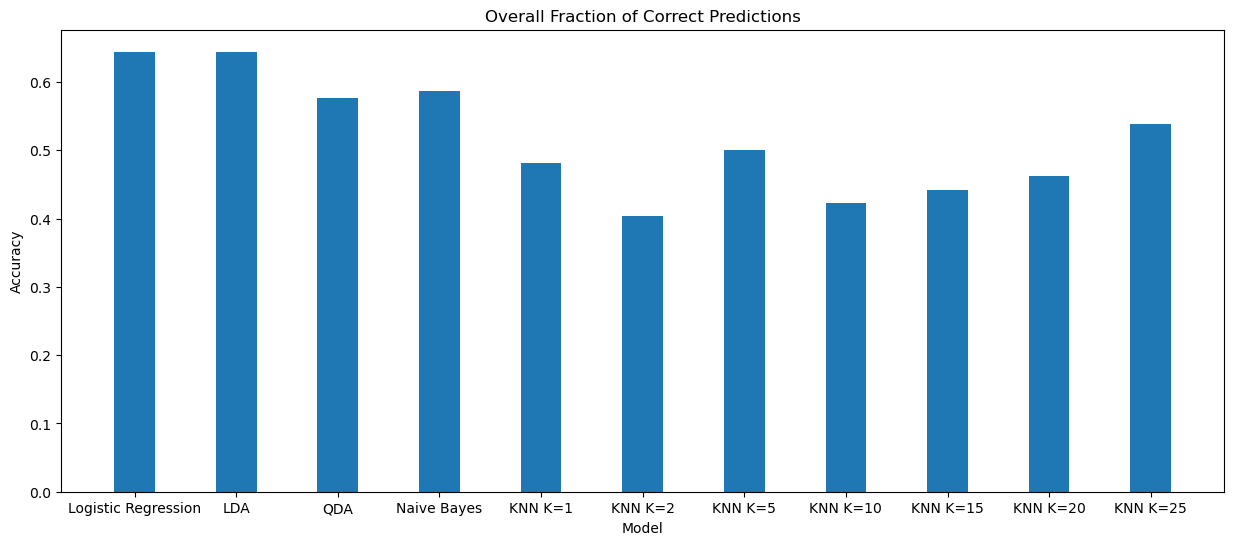

{'Logistic Regression': 0.6442307692307693, 'LDA': 0.6442307692307693, 'QDA': 0.5769230769230769, 'Naive Bayes': 0.5865384615384616, 'KNN K=1': 0.4807692307692308, 'KNN K=2': 0.40384615384615385, 'KNN K=5': 0.5, 'KNN K=10': 0.4230769230769231, 'KNN K=15': 0.4423076923076923, 'KNN K=20': 0.46153846153846156, 'KNN K=25': 0.5384615384615384}

 Max: (0.6442307692307693, 'Logistic Regression')


In [98]:
model = MS(['Lag2', ('Lag1', 'Lag3', 'Lag4')]).fit(Weekly)
X = model.transform(Weekly)
compareModels(X, Weekly, train)

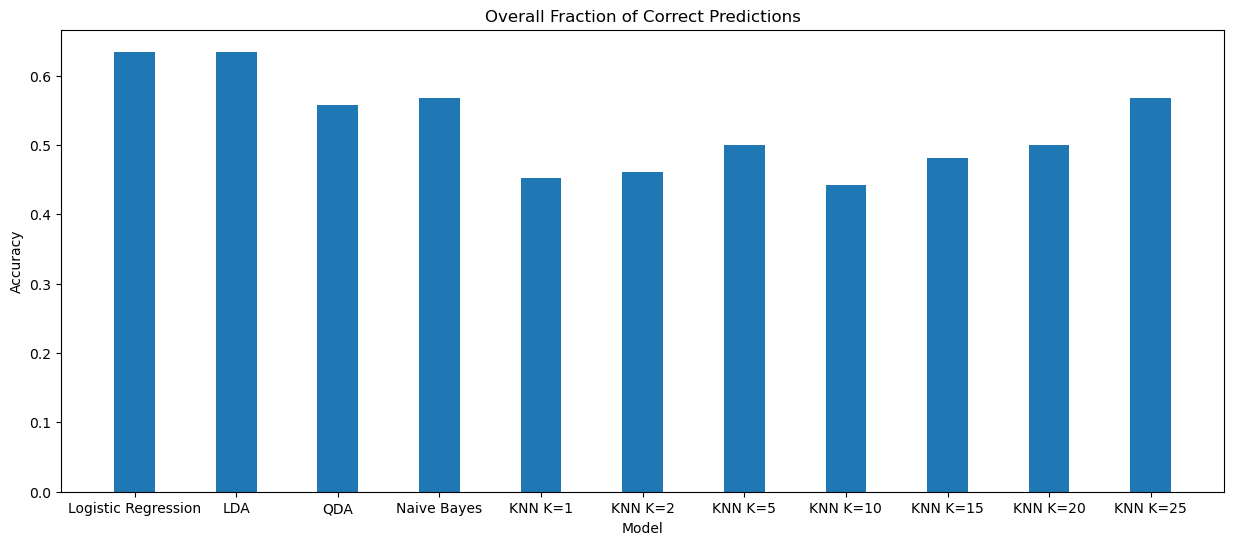

{'Logistic Regression': 0.6346153846153846, 'LDA': 0.6346153846153846, 'QDA': 0.5576923076923077, 'Naive Bayes': 0.5673076923076923, 'KNN K=1': 0.4519230769230769, 'KNN K=2': 0.46153846153846156, 'KNN K=5': 0.5, 'KNN K=10': 0.4423076923076923, 'KNN K=15': 0.4807692307692308, 'KNN K=20': 0.5, 'KNN K=25': 0.5673076923076923}

 Max: (0.6346153846153846, 'Logistic Regression')


In [99]:
model = MS(['Lag2', ('Lag1', 'Lag3', 'Lag4', 'Lag5')]).fit(Weekly)
X = model.transform(Weekly)
compareModels(X, Weekly, train)

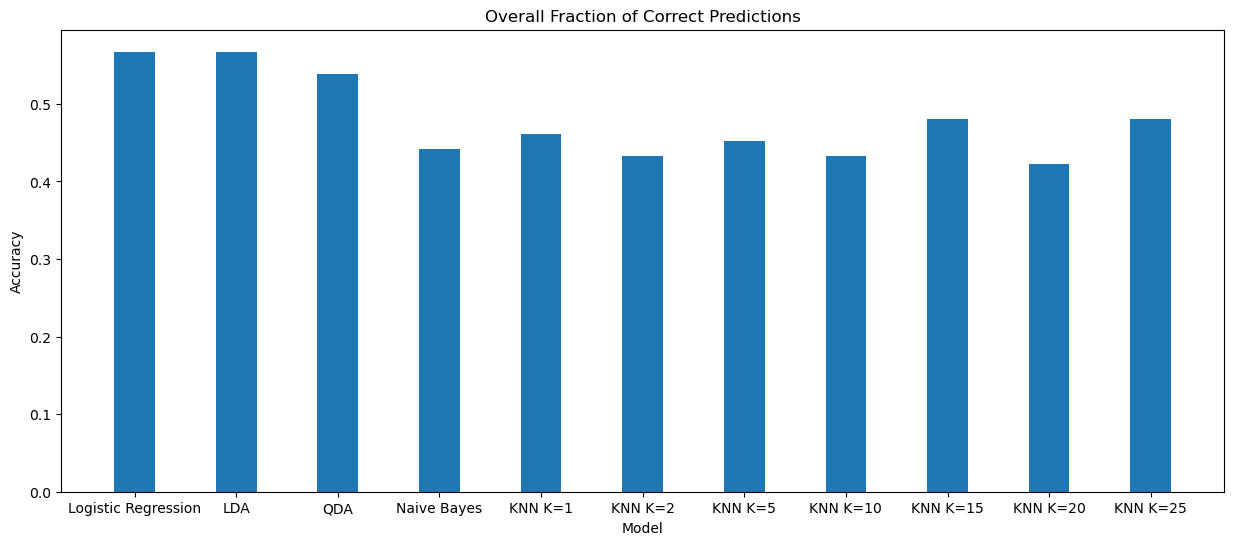

{'Logistic Regression': 0.5673076923076923, 'LDA': 0.5673076923076923, 'QDA': 0.5384615384615384, 'Naive Bayes': 0.4423076923076923, 'KNN K=1': 0.46153846153846156, 'KNN K=2': 0.4326923076923077, 'KNN K=5': 0.4519230769230769, 'KNN K=10': 0.4326923076923077, 'KNN K=15': 0.4807692307692308, 'KNN K=20': 0.4230769230769231, 'KNN K=25': 0.4807692307692308}

 Max: (0.5673076923076923, 'Logistic Regression')


In [100]:
model = MS(['Lag2', ('Lag1', 'Lag3', 'Lag4'), 'Volume']).fit(Weekly)
X = model.transform(Weekly)
compareModels(X, Weekly, train)

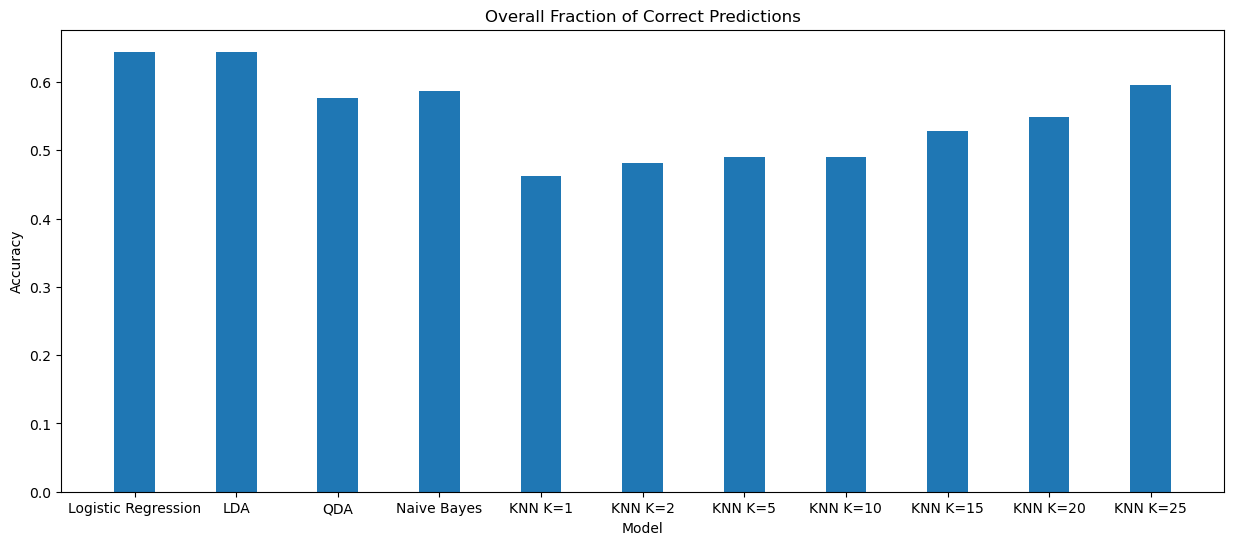

{'Logistic Regression': 0.6442307692307693, 'LDA': 0.6442307692307693, 'QDA': 0.5769230769230769, 'Naive Bayes': 0.5865384615384616, 'KNN K=1': 0.46153846153846156, 'KNN K=2': 0.4807692307692308, 'KNN K=5': 0.49038461538461536, 'KNN K=10': 0.49038461538461536, 'KNN K=15': 0.5288461538461539, 'KNN K=20': 0.5480769230769231, 'KNN K=25': 0.5961538461538461}

 Max: (0.6442307692307693, 'Logistic Regression')


In [102]:
model = MS(['Lag2', ('Lag1', 'Lag3', 'Lag4', 'Volume')]).fit(Weekly)
X = model.transform(Weekly)
compareModels(X, Weekly, train)

**Transformation of Predictors:** $X^2$

Taking top 4 attempts and playing with transformations.

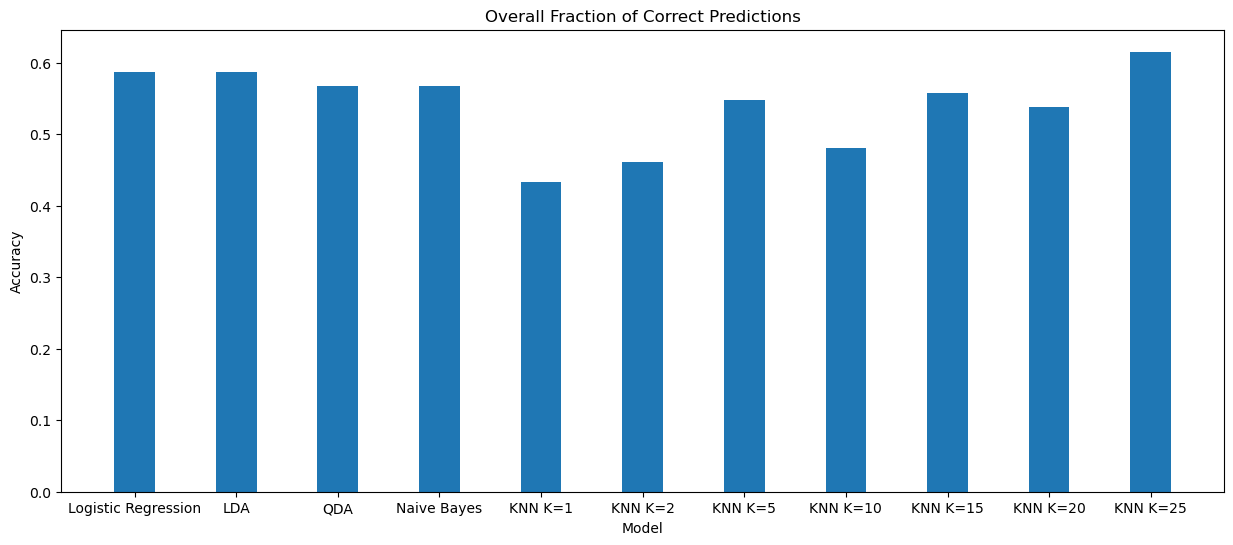

{'Logistic Regression': 0.5865384615384616, 'LDA': 0.5865384615384616, 'QDA': 0.5673076923076923, 'Naive Bayes': 0.5673076923076923, 'KNN K=1': 0.4326923076923077, 'KNN K=2': 0.46153846153846156, 'KNN K=5': 0.5480769230769231, 'KNN K=10': 0.4807692307692308, 'KNN K=15': 0.5576923076923077, 'KNN K=20': 0.5384615384615384, 'KNN K=25': 0.6153846153846154}

 Max: (0.6153846153846154, 'KNN K=25')


In [115]:
model = MS(['Lag2', ('Lag1', 'Lag3', 'Lag4', 'Volume')]).fit(Weekly)
X = model.transform(Weekly)
X['Lag2'] = X['Lag2']**2
compareModels(X, Weekly, train)

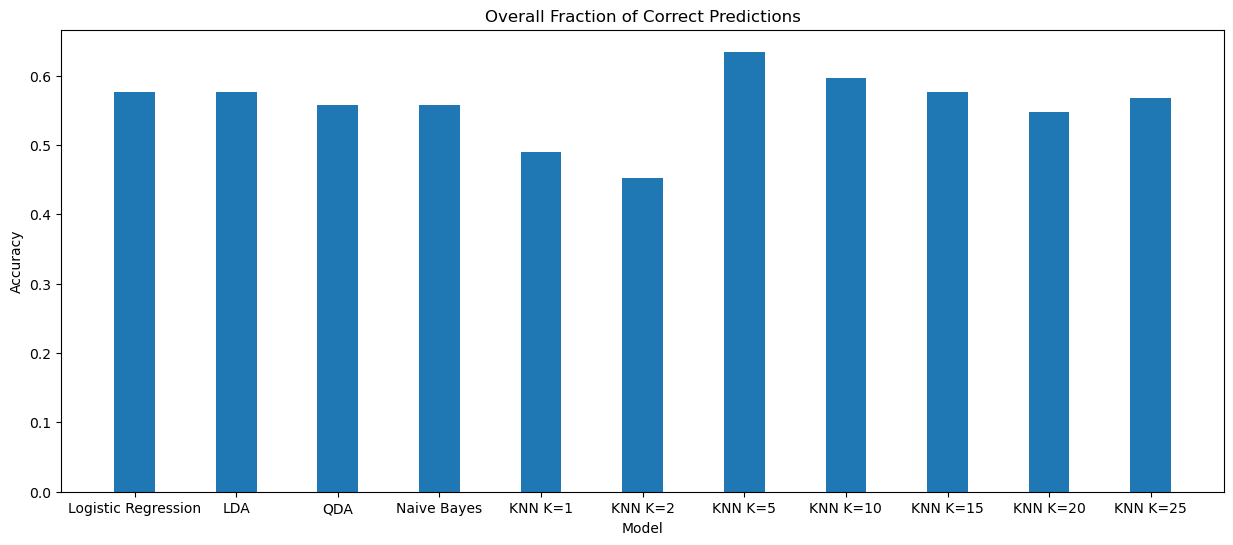

{'Logistic Regression': 0.5769230769230769, 'LDA': 0.5769230769230769, 'QDA': 0.5576923076923077, 'Naive Bayes': 0.5576923076923077, 'KNN K=1': 0.49038461538461536, 'KNN K=2': 0.4519230769230769, 'KNN K=5': 0.6346153846153846, 'KNN K=10': 0.5961538461538461, 'KNN K=15': 0.5769230769230769, 'KNN K=20': 0.5480769230769231, 'KNN K=25': 0.5673076923076923}

 Max: (0.6346153846153846, 'KNN K=5')


In [118]:
model = MS(['Lag2', ('Lag1', 'Lag3', 'Lag4', 'Lag5')]).fit(Weekly)
X = model.transform(Weekly)
X['Lag2'] = X['Lag2']**2
compareModels(X, Weekly, train)

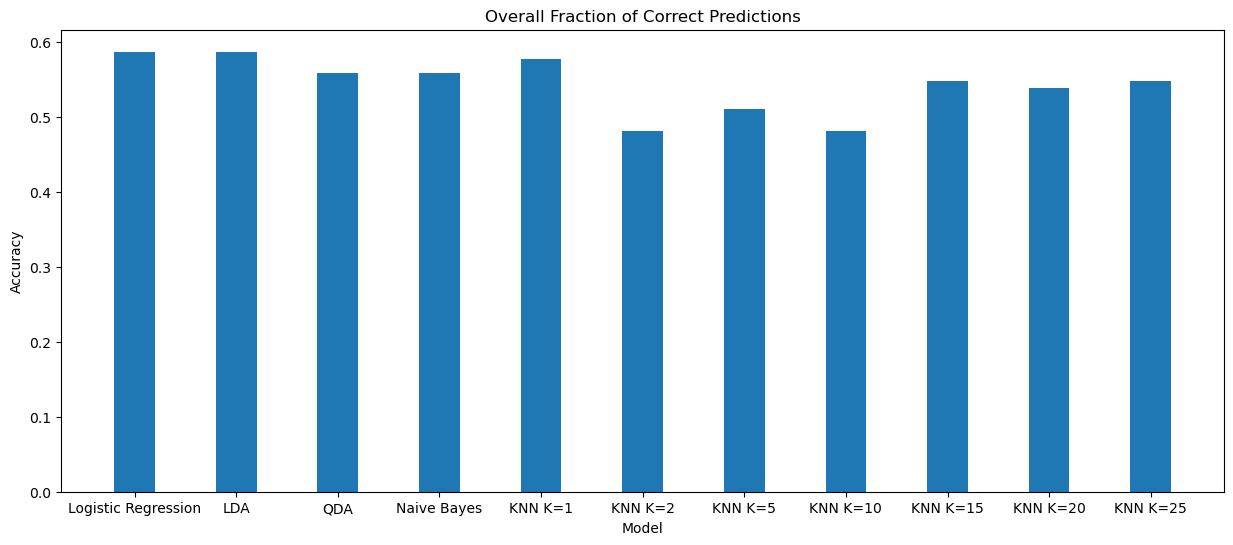

{'Logistic Regression': 0.5865384615384616, 'LDA': 0.5865384615384616, 'QDA': 0.5576923076923077, 'Naive Bayes': 0.5576923076923077, 'KNN K=1': 0.5769230769230769, 'KNN K=2': 0.4807692307692308, 'KNN K=5': 0.5096153846153846, 'KNN K=10': 0.4807692307692308, 'KNN K=15': 0.5480769230769231, 'KNN K=20': 0.5384615384615384, 'KNN K=25': 0.5480769230769231}

 Max: (0.5865384615384616, 'Logistic Regression')


In [119]:
model = MS(['Lag2', ('Lag1', 'Lag3', 'Lag4')]).fit(Weekly)
X = model.transform(Weekly)
X['Lag2'] = X['Lag2']**2
compareModels(X, Weekly, train)

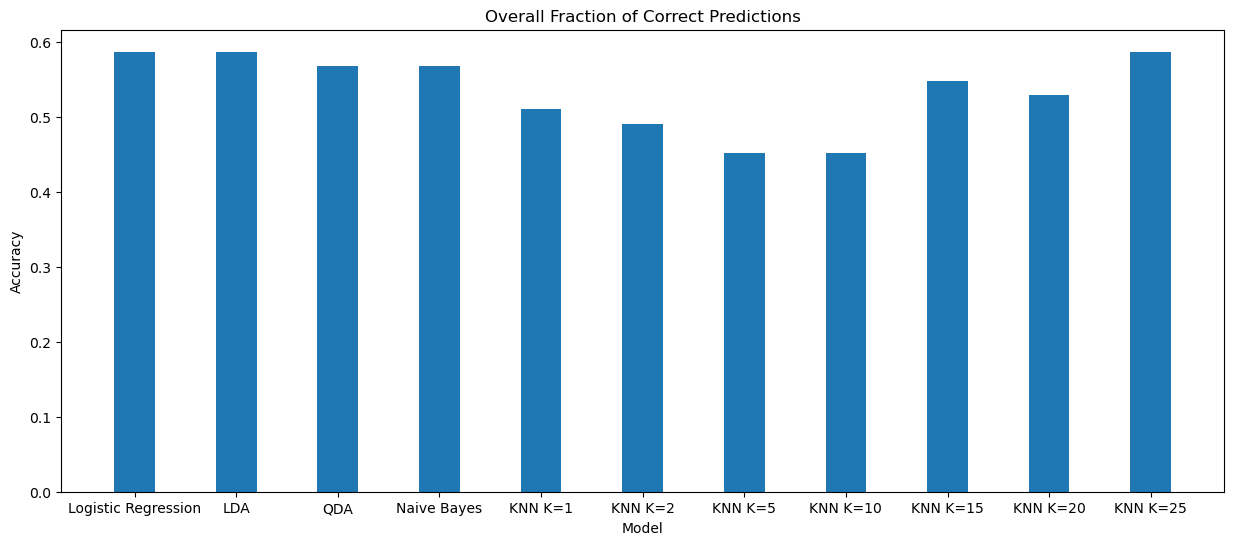

{'Logistic Regression': 0.5865384615384616, 'LDA': 0.5865384615384616, 'QDA': 0.5673076923076923, 'Naive Bayes': 0.5673076923076923, 'KNN K=1': 0.5096153846153846, 'KNN K=2': 0.49038461538461536, 'KNN K=5': 0.4519230769230769, 'KNN K=10': 0.4519230769230769, 'KNN K=15': 0.5480769230769231, 'KNN K=20': 0.5288461538461539, 'KNN K=25': 0.5865384615384616}

 Max: (0.5865384615384616, 'Logistic Regression')


In [120]:
model = MS(['Lag2']).fit(Weekly)
X = model.transform(Weekly)
X['Lag2'] = X['Lag2']**2
compareModels(X, Weekly, train)

**Variables, method, and confusion matrix of best run**

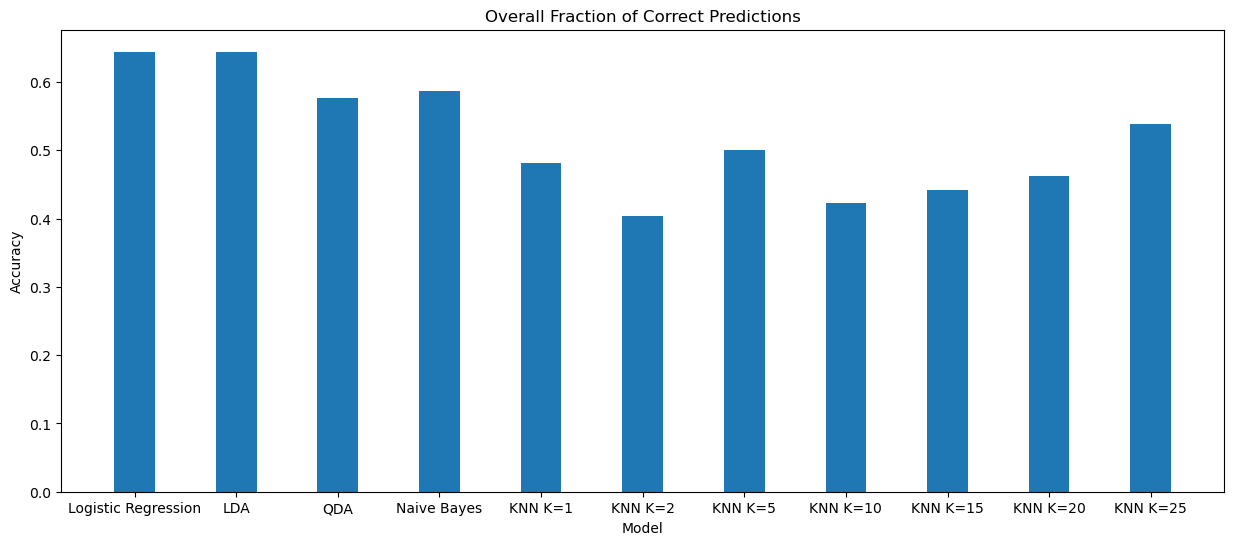

{'Logistic Regression': 0.6442307692307693, 'LDA': 0.6442307692307693, 'QDA': 0.5769230769230769, 'Naive Bayes': 0.5865384615384616, 'KNN K=1': 0.4807692307692308, 'KNN K=2': 0.40384615384615385, 'KNN K=5': 0.5, 'KNN K=10': 0.4230769230769231, 'KNN K=15': 0.4423076923076923, 'KNN K=20': 0.46153846153846156, 'KNN K=25': 0.5384615384615384}

 Max: (0.6442307692307693, 'Logistic Regression') 

 Truth      Down  Up
Predicted          
Down          9   3
Up           34  58


In [129]:
model = MS(['Lag2', ('Lag1', 'Lag3', 'Lag4')]).fit(Weekly)
X = model.transform(Weekly)
compareModels(X, Weekly, train)

In [130]:
(9+58)/104

0.6442307692307693